# Evaluating LLMs

Evaluating models depends on the task you want to evaluate on.  
There are a few types of evaluation:
- **Automated Evaluation (Benchmarking with known quantities)**  
    This is one of the simpler types. When you have a question and a strict answer, you can automate the evaluation.  
    Example:  
    ```  
    Question: "What is the capital of Romania?"
    Answer: "Bucharest" / "București" (and lowercase variants)
    ```  

    ```  
    Question: What is 2 + 2?
    A. 3
    B. 4
    C. 5
    Answer: B
    ```  

    Answers are easy to parse and other responses are wrong.  

- **Model in the loop Evaluation (Model as a judge)**  
    This is a more complex type, but still automatable using a second competent LLM, called a judge.

    Example:
    ```  
    Input: What if these shoes don't fit?
    Expected: You're eligible for a free full refund within 30 days of purchase.
    Predicted: We offer a 30-day full refund at no extra cost.
    ```

    In this case, the judge LLM is given the input, the expected answer and the predicted answer.  
    It then decides if the predicted answer is correct or not.

- **Human in the loop Evaluation (Human as a judge)**  
    This is the most complex type, but also the most accurate, as it can account for nuances, emotions, and has deeper understanding of the task.  
    The human judge is given the input, the expected answer and the predicted answer.  
    The human judge then decides if the prediction is correct.

--- 

There are multiple harnesses available for evaluation:
- [lm-evaluation-harness](https://github.com/EleutherAI/lm-evaluation-harness/blob/main/examples/lm-eval-overview.ipynb)
- [deepeval](https://github.com/confident-ai/deepeval/blob/main/examples/getting_started/test_example.py)
- [MLflow](https://mlflow.org/docs/latest/llms/llm-evaluate/index.html)

We will be implementing a simple evaluation methodology for a single-choice question as an exercise.  
`RoBiology/RoBiologyDataChoiceQA` filtered on a single-choice question will be our benchmark.

In [1]:
!pip install -q transformers datasets torch unsloth ipywidgets scikit-learn numpy plotly pandas matplotlib hf_transfer
import os
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Initializing the testing environment

Loading the dataset:

In [2]:
from datasets import load_dataset

dataset = load_dataset("RoBiology/RoBiologyDataChoiceQA")
dataset

DatasetDict({
    train: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 11368
    })
    validation: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 1376
    })
    test: Dataset({
        features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
        num_rows: 1388
    })
})

In [3]:
test_ds = dataset['test'].filter(lambda x: x['type'] == 'single-choice')
test_ds

Dataset({
    features: ['question_number', 'question', 'type', 'options', 'grade', 'stage', 'year', 'right_answer', 'source', 'id_in_source', 'dupe_id'],
    num_rows: 588
})

Loading the tokenizer and model:

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained("unsloth/Llama-3.2-3B-Instruct", device_map='cuda')

Setting up the input for the model:

In [5]:
def create_chat_prompt(instruction: str, input: str, response: str|None = None):
    return tokenizer.apply_chat_template(
        [
            {"role": "system", "content": instruction},
            {"role": "user", "content": input},
            *([{"role": "assistant", "content": response}] if response else []),
        ],
        tokenize=False,
        add_generation_prompt=True,
    )

In [6]:
instuction = "Answer the question based on the given options. Respond by writing only the letter of the correct answer."

print(create_chat_prompt(
    instuction,
    "\n".join([test_ds[0]["question"]] + test_ds[0]["options"]),
    # test_ds[0]["right_answer"],
))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 08 Dec 2024

Answer the question based on the given options. Respond by writing only the letter of the correct answer.<|eot_id|><|start_header_id|>user<|end_header_id|>

Următorul reflex este monosinaptic:
A. rotulian
B. cardioaccelerator
C. de apărare
D. vasoconstrictor<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [7]:
test_ds = test_ds.map(lambda x: {
    "chat": create_chat_prompt(instuction, '\n'.join([x['question']] + x['options'])) 
})

## Running the model

We are using a simple evaluation methodology:
- Prefill the model with the chat prompt
- Generate the probability distribution for the next token
- Save the most likely token
- Save the top 10 tokens and their scores

Generation is done without any sampling (and temperature = 0).  
The probability distribution untouched, as outputed from the model.  
This is to have a deterministic evaluation.

---

Since we are evaluating a single-choice question, we can use the most likely token as the prediction, but for multiple-choice where multiple tokens have to be selected, a different approach would be needed.


In [8]:
from tqdm import tqdm
import torch


def test_model(model, seed=42, do_sample=False, temperature=0):
    answers = []

    for entry in tqdm(test_ds):
        # set seed
        torch.manual_seed(seed)

        # tokenize
        input = tokenizer(
            entry["chat"],
            return_tensors="pt",
        ).to(model.device)

        # generate and return sequence, scores and logits, with given temperature and sampling
        response = model.generate(
            **input,
            max_new_tokens=1,
            do_sample=do_sample,
            temperature=temperature,
            return_dict_in_generate=True,
            output_scores=True,
            output_logits=True,
            pad_token_id=tokenizer.eos_token_id,
        )

        # decode answer
        output = tokenizer.decode(
            response["sequences"][0][input.input_ids.shape[1] :],
            skip_special_tokens=True,
        ).strip()

        # get top 10 tokens and scores
        scores = response["scores"][0]
        top_k = scores.topk(10)
        top_k_tokens = tokenizer.convert_ids_to_tokens(top_k.indices.reshape(-1, 1))

        # append to answers
        answers.append(
            {
                "pred": output,
                "top_k_tokens": top_k_tokens,
                "top_k_scores": top_k.values.tolist()[0],
            }
        )

    return answers


with torch.no_grad():
    answers = test_model(model)

  0%|          | 0/588 [00:00<?, ?it/s]/home/stefan/laborator/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/stefan/laborator/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.
  0%|          | 1/588 [00:00<06:10,  1.58it/s]/home/stefan/labor

Example of an output:


In [9]:
answers[0]

{'pred': 'A',
 'top_k_tokens': ['A', 'B', 'D', 'C', 'R', 'V', 'E', 'U', 'M', 'S'],
 'top_k_scores': [27.942733764648438,
  27.89405059814453,
  27.47077751159668,
  26.390111923217773,
  19.076398849487305,
  18.385112762451172,
  18.295764923095703,
  17.976375579833984,
  17.62354278564453,
  17.048017501831055]}

## Process results

Merge test dataset with answers:

In [10]:
import pandas as pd
test_df = pd.DataFrame(test_ds)
answers_df = pd.DataFrame(answers).rename(columns={'output': 'pred'})

answers_df = test_df.join(answers_df)
answers_df

,question_number,question,type,options,grade,stage,year,right_answer,source,id_in_source,dupe_id,chat,pred,top_k_tokens,top_k_scores
0,30,Următorul reflex este monosinaptic:,single-choice,"[A. rotulian, B. cardioaccelerator, C. de apăr...",VII,locala,2018,A,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,A,"[A, B, D, C, R, V, E, U, M, S]","[27.942733764648438, 27.89405059814453, 27.470..."
1,25,Axonii neuronilor olfactivi străbat lama ciuru...,single-choice,"[A. etmoid, B. sfenoid, C. zigomatic, D. frontal]",VII,locala,2018,A,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,A,"[A, B, C, D, E, S, R, M, V, T]","[29.128841400146484, 28.690753936767578, 25.94..."
2,24,Astigmatismul:,single-choice,[A. este un defect care nu afectează sistemul ...,VII,locala,2018,C,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,C,"[C, B, A, D, R, E, M, V, L, O]","[26.928300857543945, 25.83871841430664, 25.774..."
3,22,Structuri bogat vascularizate sunt:,single-choice,"[A. coroida, dermul, B. corneea, mucoasa nazal...",VII,locala,2018,A,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,A,"[A, B, D, C, R, E, V, M, S, P]","[26.416179656982422, 26.19873046875, 25.524808..."
4,20,Arcul reflex:,single-choice,"[A. este format din 3 componente, B. reprezint...",VII,locala,2018,B,olimpiada,arad,None,<|begin_of_text|><|start_header_id|>system<|en...,B,"[B, A, C, D, R, E, T, V, S, O]","[28.546669006347656, 27.383541107177734, 27.12..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,39,Glicoliza anaerobă se caracterizează prin urmă...,single-choice,"[A. randament foarte ridicat, B. transformarea...",facultate,admitere,2020,A,UMF Brasov,metabolismul/varianta_B,None,<|begin_of_text|><|start_header_id|>system<|en...,D,"[D, B, E, A, C, R, G, O, F, S]","[25.47475814819336, 24.43821144104004, 24.4042..."
584,1,Alegeți afirmația incorectă referitoare la aci...,single-choice,[A. prin reacția de beta-oxidare duc la formar...,facultate,admitere,2020,C,UMF Brasov,metabolismul/varianta_B,None,<|begin_of_text|><|start_header_id|>system<|en...,A,"[A, C, B, E, D, R, O, M, L, F]","[22.201313018798828, 21.998310089111328, 21.82..."
585,21,Care dintre următorii hormoni au rol predomina...,single-choice,"[A. hormonul somatotrop, B. testosteronul, C. ...",facultate,admitere,2020,C,UMF Brasov,metabolismul/varianta_A,None,<|begin_of_text|><|start_header_id|>system<|en...,C,"[C, A, B, D, E, R, F, M, V, S]","[27.479848861694336, 25.796890258789062, 25.41..."
586,11,Despre rolurile lipidelor în organism nu se po...,single-choice,[A. lipidele aflate în organism reprezintă o r...,facultate,admitere,2020,A,UMF Brasov,metabolismul/varianta_A,None,<|begin_of_text|><|start_header_id|>system<|en...,C,"[C, B, D, E, A, R, O, F, M, P]","[24.079145431518555, 23.989465713500977, 23.46..."


Show ground truth:

In [16]:
answers_df['right_answer'].value_counts()

right_answer
C    185
D    147
B    147
A     98
E     11
Name: count, dtype: int64

Show predictions:

In [11]:
answers_df['pred'].value_counts()

pred
B    196
A    184
C    135
D     70
E      3
Name: count, dtype: int64

Compute accuracy:

In [13]:
answers_df['correct'] = answers_df['right_answer'] == answers_df['pred']
print(f'Accuracy: {answers_df["correct"].mean() * 100:.2f}%')
answers_df['correct'].value_counts()

Accuracy: 30.61%


correct
False    408
True     180
Name: count, dtype: int64

Show a confusion matrix.

A confusion matrix is a table that is used to evaluate the performance of a classification model.
It shows the number of correct and incorrect predictions for each class.

On Y we have the true labels and on X we have the predicted labels.

When a model has a high accuracy, the confusion matrix should have a strong first diagonal, where there are many values for A=A, B=B, C=C, etc.  
When the confusion matrix is spread out, more diffused, the model has a hard time distinguishing between classes. (A=>B, A=>C, B=>A, C=>D, etc.)

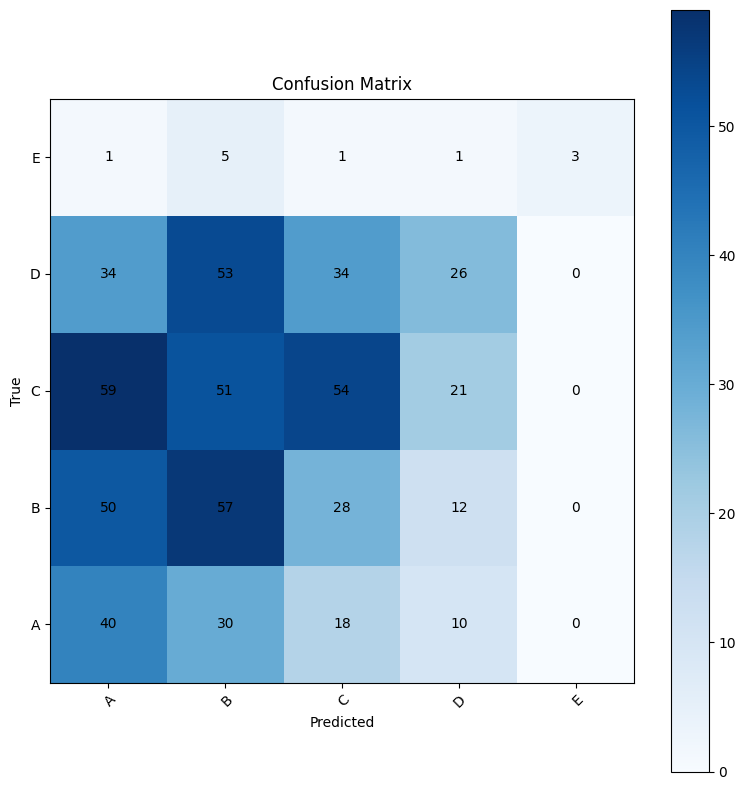

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def show_confusion_matrix(df):
    # Extract true and predicted labels
    y_true = df['right_answer'].tolist()
    y_pred = df['pred'].tolist()

    # Get unique labels in sorted order
    labels = sorted(list(set(y_true + y_pred)))

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create heatmap with origin='lower' to start from bottom
    im = ax.imshow(cm, cmap='Blues', origin='lower')

    # Add colorbar
    plt.colorbar(im)

    # Show all ticks and label them
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, cm[i, j],
                         ha="center", va="center", color="black")

    # Add labels and title
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

    # Ensure the plot is tight in the figure
    plt.tight_layout()
    
    plt.show()

show_confusion_matrix(answers_df)

As you can observe, the model is not very confident about its predictions.  
The confusion matrix should show a strong 1st degree diagonal, but the answers are spread over the entire matrix.

Let's inspect the individual predictions and look at:
- the top 10 predicted tokens and their scores
- the softmax scores for the top 10 tokens


Următorul reflex este monosinaptic:
A. rotulian
B. cardioaccelerator
C. de apărare
D. vasoconstrictor

✅A: 35.86%
---
❌B: 34.16%
❌D: 22.37%
❌C: 7.59%



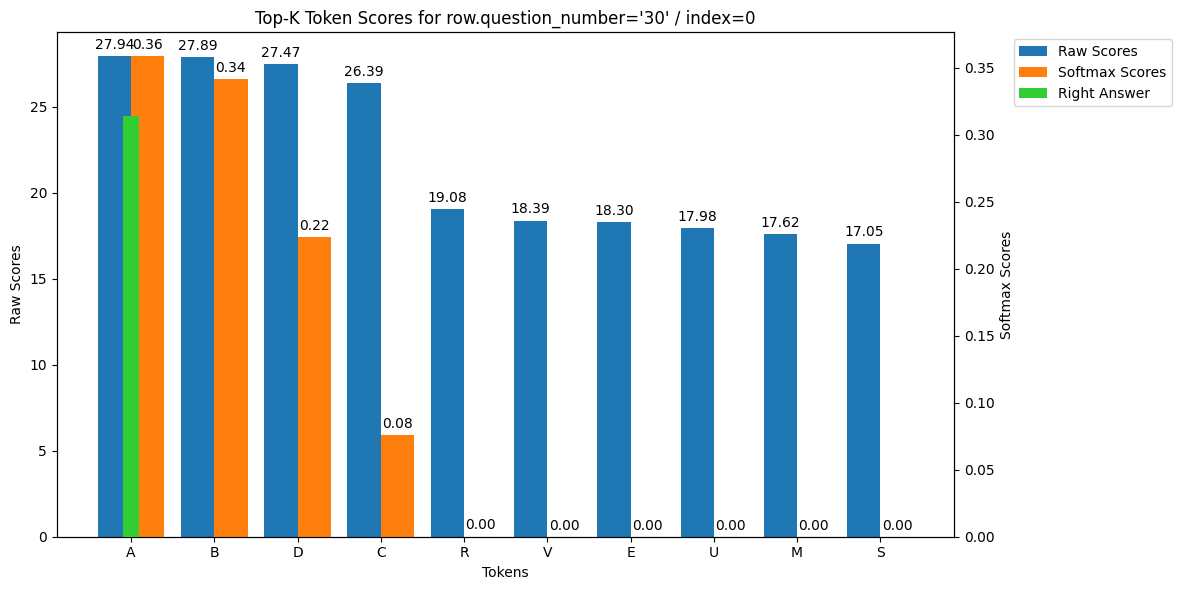

In [14]:
import matplotlib.pyplot as plt
def show_chart_for_row(row, index):
    NL = '\n'
    row_scores = row['top_k_scores']
    row_scores_softmax = torch.softmax(torch.tensor(row_scores), dim=0).numpy()  #
    row_tokens = row['top_k_tokens']

    print(f'''
{row.question}
{NL.join(row.options)}

{"✅" if row.right_answer == row_tokens[0] else "❌"}{row_tokens[0]}: {row_scores_softmax[0] * 100:.2f}%
---
{NL.join([f'{"✅" if row.right_answer == t else "❌"}{t}: {s * 100:.2f}%' for t, s in zip(row_tokens, row_scores_softmax)][1:len(row.options)])}
''')

    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    
    # Set the position of the third y-axis
    ax3.spines['right'].set_position(('axes', 1.15))

    # Plot raw scores
    x = np.arange(len(row_tokens))
    raw_bars = ax1.bar(x - 0.2, row_scores, 0.4, label='Raw Scores', color='#1f77b4')
    ax1.bar_label(raw_bars, fmt='%.2f', padding=3)
    
    # Plot softmax scores
    softmax_bars = ax2.bar(x + 0.2, row_scores_softmax, 0.4, label='Softmax Scores', color='#ff7f0e')
    ax2.bar_label(softmax_bars, fmt='%.2f', padding=3)
    
    # Plot right answer indicator
    right_answer_values = [1 if token == row.right_answer else 0 for token in row_tokens]
    right_bars = ax3.bar(x, right_answer_values, 0.2, label='Right Answer', color='limegreen')
    
    # Set labels and title
    ax1.set_xlabel('Tokens')
    ax1.set_ylabel('Raw Scores')
    ax2.set_ylabel('Softmax Scores')
    ax3.set_ylabel('Right Answer')
    
    plt.title(f'Top-K Token Scores for {row.question_number=} / {index=}')
    
    # Set x-axis ticks
    plt.xticks(x, row_tokens)
    
    # Set y-axis limits for right answer indicator
    ax3.set_ylim(0, 1.2)
    ax3.set_yticks([])  # Hide y-ticks for right answer
    
    # Hide all spines and labels for ax3
    ax3.set_frame_on(False)
    ax3.set_ylabel('')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, 
              loc='upper right', bbox_to_anchor=(1.25, 1))
    
    plt.tight_layout()
    plt.show()

# Create buttons for navigation
from ipywidgets import Button, HBox, widgets
import IPython.display as display

current_index = 0

def show_prev(_):
    global current_index
    current_index = max(0, current_index - 1)
    display.clear_output(wait=True)
    display_buttons()
    show_chart_for_row(answers_df.iloc[current_index], current_index)

def show_next(_):
    global current_index 
    current_index = min(len(answers_df) - 1, current_index + 1)
    display.clear_output(wait=True)
    display_buttons()
    show_chart_for_row(answers_df.iloc[current_index], current_index)

def on_index_change(change):
    global current_index
    current_index = max(0, min(change.new, len(answers_df)-1))
    display.clear_output(wait=True)
    display_buttons()
    show_chart_for_row(answers_df.iloc[current_index], current_index)

def display_buttons():
    prev_button = Button(description='Previous')
    next_button = Button(description='Next')
    index_input = widgets.IntText(
        value=current_index,
        description='Index:',
        min=0,
        max=len(answers_df)-1
    )
    prev_button.on_click(show_prev)
    next_button.on_click(show_next)
    index_input.observe(on_index_change, names='value')
    display.display(HBox([prev_button, next_button, index_input]))

# Show initial chart and buttons
display_buttons()
show_chart_for_row(answers_df.iloc[current_index], current_index)

Here are a few observations:
- Index 0:
  - Model is not confident in its prediction, having A and B with similar scores (36%, 34% respectively)
  - The correct answer is A (36%) which is the one predicted, but confidence is low
- Index 2:
  - Model is somewhat confident in it's prediction of C (59%) which is correct
- Index 5: 
  - Model is not confident, and the correct answer (C) is 4th on the list of probabilities (15%)
- Index 8:
  - Model is somewhat confidently wrong, having picked D (53%) instead of the correct answer A (15%)
- Index 16, 19, 20: 
  - Strong confidence in the correct answer
- Index 34:
  - Strong confidence in the wrong answer

Let's add softmax to our dataframe and filter based on a confidence threshold.

In [15]:
answers_df['top_k_scores_softmax'] = answers_df['top_k_scores'].apply(lambda x: torch.softmax(torch.tensor(x), dim=0).numpy())
confident_threshold = 0.5
confident_answers = answers_df[answers_df['top_k_scores_softmax'].apply(lambda x: x[0] > confident_threshold)]

In [16]:
print(f'Confident answers: {confident_answers.shape[0] / answers_df.shape[0] * 100:.2f}%')
print(f'Accuracy: {confident_answers["correct"].mean() * 100:.2f}%')

Confident answers: 29.76%
Accuracy: 42.86%


We can see that about 30% of the answers are confident at a 50% threshold.  
The accuracy is also increased to 42%

Showing the confusion matrix one more time, we can see that the first diagonal is much stronger.

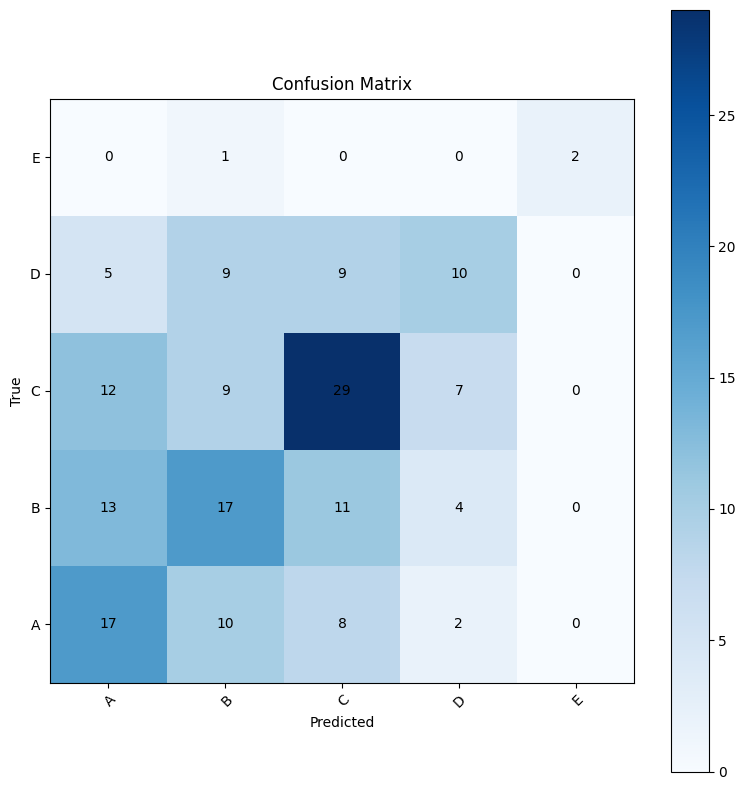

In [17]:
show_confusion_matrix(confident_answers)